# DL Lab 2.2 - Homework - Transfer Learning and Fine-Tuning of Pretrained Models

In the last lab, you built a simple ConvNet, trained it from scratch, added augmentation and regularization techniques, and achieved about 90% accuracy.

In this homework, you will use two techniques for (re-)using the "experience" stored in **pre-trained** models. These techniques are extremely useful if you don't have suffcient data for training a bigger model from scratch. Data such as our images of bees or flowers. ;-)

In detail, you will use **transfer learning** and **fine-tuning** of a model that was already trained on a very large dataset, namely the *ImageNet ILSVRC* data.

In the end, you will investigate how our ConvNet actually perceives and recognizes the given data by **visualizing feature maps** as well performing **Activation Maximization**.

***

**After completing this homework you will be able to**

- Use **pretrained models** for **transfer-learning** and **fine-tuning**
- alter the **train scope** of specific layers of your models
- **interprete** what your model has learned.

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines marked by "<font color='green'>`# TODO`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle.tu-ilmenau.de/mod/forum/view.php?id=3371) in Moodle.

Let's get started!

***

**Note**: Training a ConvNet is a computationally expensive process. Most of the computations can be parallelized very efficently, making them a perfect fit for GPU-acceleration. In order to enable a GPU for your Colab session, do the following steps:
- Click '*Runtime*' -> '*Change runtime type*'
- In the pop-up window for '*Hardware accelerator*', select '*GPU*'
- Click '*Save*'

# 0 - Test for GPU

Execute the code below for printing the TF version and testing for GPU availability.

In [ ]:
#@title Print TF version and GPU stats

import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf

print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.15.0
Found GPU at: /device:GPU:0

Thu May 30 09:20:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0              29W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------

# 1 - Download and Prepare Data

In [ ]:
#@title Dataset Downloader
archive = "DL_2_1.zip"
ds_archive = "ToBeeOrNotToBee_small_nopad_256px.zip"
dataset_dir = ds_archive.replace(".zip", "")

url = "https://cloud.tu-ilmenau.de/s/yb2A6FDzj2kSNTN/download" # ToBeeOrNotToBee_small_nopad_256px
!wget -nv --retry-connrefused --waitretry=1 --read-timeout=20 --timeout=15 -t 0 --show-progress -O $archive $url
!unzip -j $archive
!unzip -qd $dataset_dir $ds_archive

import utils

DL_2_1.zip              [           <=>      ]   5.20M  2.49MB/s    in 2.1s    
2024-05-30 09:20:53 URL:https://cloud.tu-ilmenau.de/s/yb2A6FDzj2kSNTN/download [5456201] -> "DL_2_1.zip" [1]
Archive:  DL_2_1.zip
 extracting: ToBeeOrNotToBee_small_nopad_256px.zip  
 extracting: utils.py                


In [ ]:
#@title Prepare Datasets

IMG_SIZE = (256, 256)
BATCHSIZE = 64

train_ds, val_ds, test_ds, class_names = utils.load_datasets(dataset_dir)

Found 289 files belonging to 2 classes.
Found 90 files belonging to 2 classes.
Found 98 files belonging to 2 classes.
Class names: ['Bee', 'NoBee']
Image size: (256, 256)
Batchsize: 64


# 2 - Transfer-Learning Using Pretrained Models

## 2.1 - Feature Extraction for Downstream Classification

One thing that is typically done in computer vision tasks is to take a model trained on a very large dataset, e.g., the *ImageNet ILSVRC* data, and use this model for feature extraction on smaller datasets. Even though the dataset and task the model was originally trained on might be quite different to the actual dataset and task, the extracted features are typically very informative. This versatility and repurposability of ConvNets is one of the most interesting aspects of Deep Learning. The extracted features (aka **representations**) can then be used for downstream tasks such as classification.

In this homework, you will use the famous [VGG16 model](https://arxiv.org/abs/1409.1556) named after the **V**isual **G**eometry **G**roup from Oxford. The model was pre-trained on the ImageNet ILSVRC data, i.e., a large dataset of web images (1.4M images and 1000 classes). Although outperformed by more recent architectures, this simple but powerful model won the ILSVR challenge in 2014 and remains very famous for feature extraction since then. Let's see how these features help for our classification task!

First, we need to pick which intermediate layer of VGG16 we will use for feature extraction. A common practice is to use the output of the last convolution layer before the fully connected (aka dense) layers. The fully connected layers are too specialized for the original task the network was trained in. Hence using their outputs as features won't be very useful for a new task.

The zoo of pre-trained models is provided in the [`keras.applications` module](https://www.tensorflow.org/api_docs/python/tf/keras/applications) in TF. You can directly load the architecture from there. If you set `weights='imagenet'`, the `imagenet` weights will be loaded automatically.

If `include_top=False` is specified, the network is loaded without the original classification layers at the top. Instead the network's last layer is a `MaxPooling2D` layer pooling across the output of the last convolution layer.

**Task**: Complete the code below for building a feature extraction model based on the VGG16.

**Hint**: Same as layers, models can be called on tensors and return tensors.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16

def build_feature_extraction_model(input_shape, summary=True):

  # Initialize augmentation model
  augmentation_model = utils.build_augmentation_model(input_shape)

  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  # Forward through augmentation layers
  x = augmentation_model(input_img)

  ### START YOUR CODE HERE ###  (≈4 LOC)

  # Initialize the pre-trained model
  pre_trained_model = VGG16(
    include_top=False,
      input_shape=input_shape, # not necessary
  )

  # Forward through pre_trained_model
  x = pre_trained_model(x)

  # Add global maxpooling layer on output of pre-trained model
  output_features = layers.GlobalMaxPooling2D()(x)

  # define model
  feature_extraction_model = Model(
      inputs=input_img,
      outputs=output_features
  )

  ### END YOUR CODE HERE ###

  # Freeze pre-trained model
  pre_trained_model.trainable = False

  if summary:
    print(feature_extraction_model.summary())

  return feature_extraction_model

In [ ]:
INPUT_SHAPE = IMG_SIZE + (3,)

feature_extraction_model = build_feature_extraction_model(INPUT_SHAPE)

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


The list of layers of a model is accessible as property:

In [7]:
feature_extraction_model.layers

Note that models can be nested! Check the layers of the second "layer":

In [9]:
# TODO
feature_extraction_model.layers[1].layers

And print the summary of the nested VGG16:

In [10]:
# TODO
print(feature_extraction_model.layers[2].summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

You can now use the `feature_extraction_model` for computing powerful representations of the images in your dataset. We create a utility function that reads the data from the datasets in batches and accumulates the extracted features and their associated class labels in the memory:

In [11]:
def extract_features_in_batches(model, dataset, repetitions=1):
  ''' Loop over dataset batches and return extracted features and labels '''

  X, Y = ( list(), list() )

  for i in range(repetitions):

    if i:
      print('\nRepetition', i)

    # iterate over the dataset
    for batch_idx, (image_batch, label_batch) in enumerate(dataset):
      sys.stderr.write('\rbatch {}'.format(batch_idx) )
      # append true labels
      Y.extend(label_batch)
      # compute predictions
      if repetitions > 1:
        X.extend( model.call(image_batch, training=True) )
      else:
        X.extend( model.predict(image_batch, verbose=0) )

  return np.asarray(X), np.asarray(Y)

**Task**: Extract validation and training features (and their associated labels) using the `feature_extraction_model` on the `validation_generator` and the `training_generator`. For **augmenting** the training data, use **five repetitions** on the training data.

In [12]:
### START YOUR CODE HERE ###  (≈2 LOC)

# Validation features `X_val` and labels `Y_val`
X_val, Y_val = extract_features_in_batches(feature_extraction_model, val_ds)

# Training features `X_train` and labels `Y_train`
X_train, Y_train = extract_features_in_batches(feature_extraction_model, train_ds, repetitions=5)

### END YOUR CODE HERE ###

batch 4


Repetition 1


batch 4


Repetition 2


batch 4


Repetition 3


batch 4


Repetition 4


batch 4

Next, build a small Neural Network consisting of two hidden dense layers of 512 neurons each and 20% dropout, followed by a dense layer for classification. Don't forget to make reasonable decisions about the output size and the activation function.

Then compile the model.

In [15]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

def build_classifier_model(input_shape, init_lr=1e-3):

  ### START YOUR CODE HERE ### (≈8 LOC)
  input_tensor = layers.Input(shape=input_shape)
  x = layers.Dense(512, activation='sigmoid')(input_tensor)
  x = layers.Dropout(.2)(x)
  x = layers.Dense(512, activation='sigmoid')(x)
  x = layers.Dropout(.2)(x)
  output_tensor = layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input_tensor,outputs=output_tensor)

  model.compile(
      loss=BinaryCrossentropy(),
      optimizer=Adam(learning_rate=init_lr),
      metrics=[BinaryAccuracy(),]
  )

  ### END YOUR CODE HERE ###

  return model

Using the extracted features, you can now train your classification model. Let's see how it performs after 50 epochs of training:

Epoch 1/50
23/23 - 3s - loss: 0.7232 - binary_accuracy: 0.5156 - val_loss: 0.6282 - val_binary_accuracy: 0.8667 - 3s/epoch - 133ms/step
Epoch 2/50
23/23 - 0s - loss: 0.6647 - binary_accuracy: 0.6076 - val_loss: 0.6722 - val_binary_accuracy: 0.5111 - 100ms/epoch - 4ms/step
Epoch 3/50
23/23 - 0s - loss: 0.6013 - binary_accuracy: 0.7024 - val_loss: 0.5743 - val_binary_accuracy: 0.7889 - 128ms/epoch - 6ms/step
Epoch 4/50
23/23 - 0s - loss: 0.5260 - binary_accuracy: 0.8111 - val_loss: 0.4092 - val_binary_accuracy: 0.9333 - 125ms/epoch - 5ms/step
Epoch 5/50
23/23 - 0s - loss: 0.4443 - binary_accuracy: 0.8526 - val_loss: 0.4410 - val_binary_accuracy: 0.8222 - 117ms/epoch - 5ms/step
Epoch 6/50
23/23 - 0s - loss: 0.3697 - binary_accuracy: 0.8907 - val_loss: 0.3526 - val_binary_accuracy: 0.8556 - 101ms/epoch - 4ms/step
Epoch 7/50
23/23 - 0s - loss: 0.3114 - binary_accuracy: 0.9038 - val_loss: 0.2936 - val_binary_accuracy: 0.8778 - 116ms/epoch - 5ms/step
Epoch 8/50
23/23 - 0s - loss: 0.2811 - bin

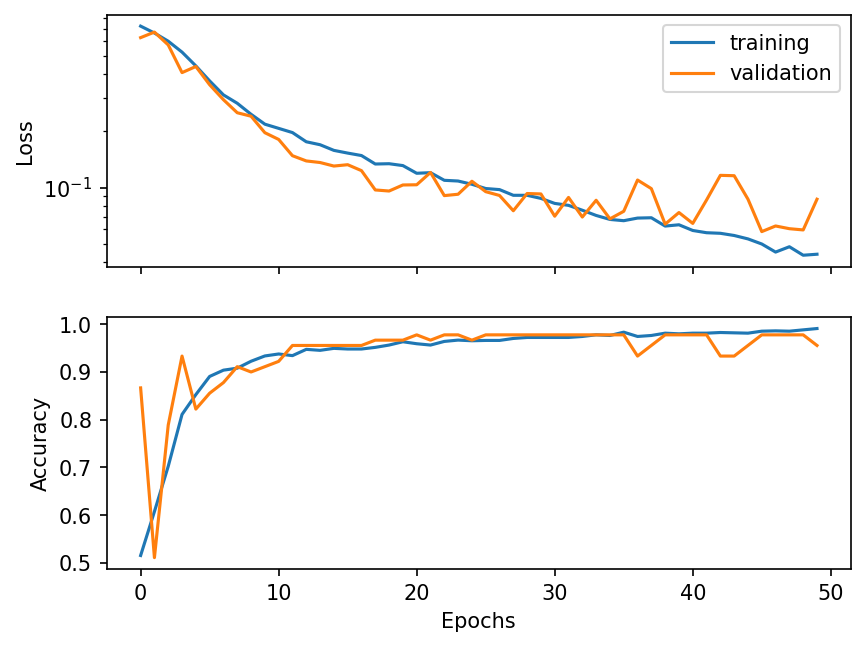

In [16]:
classifier_model = build_classifier_model( X_val.shape[1], init_lr=1e-4)

history = classifier_model.fit(
    x=X_train,
    y=Y_train,
    batch_size=BATCHSIZE,
    epochs=50,
    validation_data=(X_val, Y_val),
    verbose=2
)
utils.plot_history(history)

In [ ]:
utils.plot_history(history)

You should make two observations:

1.   Without much effort, you achieve roughly the same or higher validation accuracy as with the simple ConvNet designed in the last lab. :-D
2.   The model is converging quite fast but is plateauing on the validation data. Remember that every training image was only augmented five times.

## 2.2 - Learning new Heads on pre-trained Models

Instead of

1.   using the pre-trained ConvNet as feature extractor, and
2.   another classifier model,

you can do both steps in one and the same model.

For this, you simply add your classifier on top of your ConvNet backbone (or replace the "old" classifier by your "new" classifier).

**Task**: Complete the code below in order to add a classifier on top of the VGG16 stub.

In [17]:
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16

def build_model(input_shape, summary=True):

  # Initialize augmentation model
  augmentation_model = utils.build_augmentation_model(input_shape)

  # Initialize the pre-trained model
  pre_trained_model = VGG16(
      input_shape=input_shape,
      weights='imagenet',
      include_top=False
  )

  # Input layer returning the `input_img` tensor
  input_img = layers.Input(shape=input_shape)

  # Forward through augmentation layers
  x = augmentation_model(input_img)

  ### START YOUR CODE HERE ### (≈7 LOC)

  # Forward through pre-trained model
  x = pre_trained_model(x)

  # Add global maxpooling layer on output of pre-trained model
  x = layers.GlobalMaxPooling2D()(x)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(512, activation='relu')(x)

  # Add a dropout layer with rate 0.2
  x = layers.Dropout(.2)(x)

  # Add a fully connected layer with 512 hidden units and ReLU activation
  x = layers.Dense(512, activation='relu')(x)

  # Add a dropout layer with rate 0.2
  x = layers.Dropout(.2)(x)

  # Add a final layer for classification
  output = layers.Dense(1, activation='sigmoid')(x)

  # Define the model
  model = Model(input_img, output)

  ### END YOUR CODE HERE ###

  if summary:
    print(model.summary())

  return model, pre_trained_model

In [18]:
model, pre_trained_model = build_model(INPUT_SHAPE)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                           

You want to use the pretrained VGG16 backbone only for feature extraction. In order to prevent any weights of the pretrained model from beeing updated during training, you will **freeze** it. Only the new layers on top shall be trainable.

In Keras, you can easily access the list of layers of a model using its `layers` property. Each layer has a `trainable` property defining whether or not to update it's weights during training. You can set `trainable = False` for all layers of the pretrained VGG16 model.

Instead of setting the `trainable` property per layer, you can also set the `trainable` property of entire models!

Anyway, the model summary should tell you the reduced number of trainable parameters, amounting to ≈530k parameters. Also compare the total number of parameters: the simple ConvNet designed in last lab's homework assignment roughly had ≈24k parameters. The VGG16 based model contains ≈15M parameters!

**Task**: Freeze all weights of the `pre_trained_model`.

In [19]:
### START YOUR CODE HERE ### (≈1 LOC)
pre_trained_model.trainable = False
### END YOUR CODE HERE ###

print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                           

Whenever you change the `trainable` setting of any layer, you need to compile your model for making the changes take effect.

**Task**: Compile the model again.

In [21]:
INITIAL_LEARNING_RATE = 3e-4

### START YOUR CODE HERE ### (≈1 LOC)
model.compile(
      loss=BinaryCrossentropy(),
      optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
      metrics=[BinaryAccuracy(),]
  )
### END YOUR CODE HERE ###

Train the model for 30 epochs and check the results.

Epoch 1/30
5/5 - 28s - loss: 0.6517 - binary_accuracy: 0.6609 - val_loss: 0.3858 - val_binary_accuracy: 0.9000 - 28s/epoch - 6s/step
Epoch 2/30
5/5 - 2s - loss: 0.4660 - binary_accuracy: 0.7751 - val_loss: 0.4401 - val_binary_accuracy: 0.7778 - 2s/epoch - 492ms/step
Epoch 3/30
5/5 - 2s - loss: 0.3162 - binary_accuracy: 0.8893 - val_loss: 0.2356 - val_binary_accuracy: 0.9111 - 2s/epoch - 479ms/step
Epoch 4/30
5/5 - 2s - loss: 0.2593 - binary_accuracy: 0.8997 - val_loss: 0.2323 - val_binary_accuracy: 0.9000 - 2s/epoch - 466ms/step
Epoch 5/30
5/5 - 2s - loss: 0.2129 - binary_accuracy: 0.9239 - val_loss: 0.1670 - val_binary_accuracy: 0.9111 - 2s/epoch - 475ms/step
Epoch 6/30
5/5 - 2s - loss: 0.1941 - binary_accuracy: 0.9343 - val_loss: 0.1944 - val_binary_accuracy: 0.9000 - 2s/epoch - 479ms/step
Epoch 7/30
5/5 - 2s - loss: 0.1694 - binary_accuracy: 0.9308 - val_loss: 0.1216 - val_binary_accuracy: 0.9556 - 2s/epoch - 462ms/step
Epoch 8/30
5/5 - 2s - loss: 0.2094 - binary_accuracy: 0.9239 - 

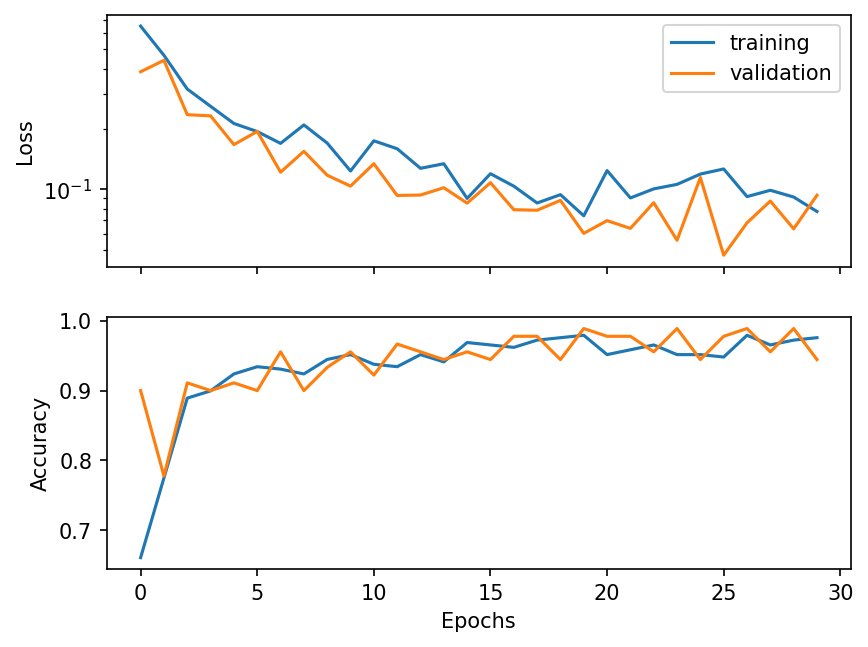

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    verbose=2
)

utils.plot_history( history )

Despite the smaller number of samples per epoch, the time for each epoch is notably larger as every image needs to be loaded from disk and propagated through the entire ConvNet. On the other hand, every image is randomly augmented in every epoch, which should increase the model's generalizability. Training for more epochs while using learning rate decay would likely improve the accuracy.

# 3 - Fine-Tuning Pre-trained Models

## 3.1 - Unfreeze Layers
In the previous two experiment, you only trained the weights of the new layers, both as independent model as well as in the joint model for feature extraction and classification. The weights of the pre-trained network were not updated during training.

To increase the accuracy, you can also **fine-tune** the weights of the pre-trained network for learning more discriminant representations of your data. All you need to to is **unfreeze** the layers of the pre-trained network. Note that you have to recompile the model in order to let this take effect. In comparison to the learning rate used during transfer learning, the learning rate used for fine-tuning is typically smaller.

**Task**: Unfreeze the layers of the pre-trained model, i.e., make them trainable. Then compile the model again and compare with the model summary.

In [23]:
INITIAL_LEARNING_RATE = 3e-5

### START YOUR CODE HERE ### (≈1 LOC)
pre_trained_model.trainable = True
### END YOUR CODE HERE ###

model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
    metrics=[BinaryAccuracy(),]
)

print(model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                           

## 3.2 - Using Callbacks

You will define [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) for scheduling the learning rate as training progresses.
Callbacks are utility classes that are called in every epoch during training. In the cell below, the custom function `lr_step_decay` defines the step-wise reduction of the learning rate by 90% after every ten epochs. The
[Learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback `LRDecayCallback` then uses this function for actually setting the learning rate.

In [24]:
def lr_step_decay(epoch, lr, drop=.9, drop_epochs=10):
  if epoch < 10:
    return INITIAL_LEARNING_RATE
  else:
    return INITIAL_LEARNING_RATE * np.power(drop, np.floor(epoch/drop_epochs))

LRDecayCallback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In addition to the learning rate callback, you will also use an [Early stopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) that stops the training process as soon as the validation loss stops decreasing. You will use this `StopCallback` for preventing your model from overfitting on the training data.

**Task**: Create an early stopping callback monitoring the validation loss and stopping the training if the validation loss did not increase for ten epochs.

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

### START YOUR CODE HERE ### (1 LOC)
StopCallback = EarlyStopping(
    patience=5,
    verbose=1,
    restore_best_weights=True
)
### END YOUR CODE HERE ###

Now, continue to train the model for a maximum of 100 epochs. Please note the VGG16 model is really large and quite slow during training.

**Task**: Add the `LRDecayCallback` and `StopCallback` to the call of the `fit` method and fine-tune your model.


Epoch 1: LearningRateScheduler setting learning rate to 3e-05.
Epoch 1/100
5/5 - 65s - loss: 0.4948 - binary_accuracy: 0.8443 - val_loss: 0.9743 - val_binary_accuracy: 0.6778 - lr: 3.0000e-05 - 65s/epoch - 13s/step

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/100
5/5 - 6s - loss: 0.2053 - binary_accuracy: 0.9343 - val_loss: 0.0688 - val_binary_accuracy: 0.9667 - lr: 3.0000e-05 - 6s/epoch - 1s/step

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/100
5/5 - 6s - loss: 0.1861 - binary_accuracy: 0.9516 - val_loss: 0.0847 - val_binary_accuracy: 0.9556 - lr: 3.0000e-05 - 6s/epoch - 1s/step

Epoch 4: LearningRateScheduler setting learning rate to 3e-05.
Epoch 4/100
5/5 - 6s - loss: 0.1122 - binary_accuracy: 0.9758 - val_loss: 0.0688 - val_binary_accuracy: 0.9778 - lr: 3.0000e-05 - 6s/epoch - 1s/step

Epoch 5: LearningRateScheduler setting learning rate to 3e-05.
Epoch 5/100
5/5 - 6s - loss: 0.0745 - binary_accuracy: 0.9689 - val_loss: 0.0648 

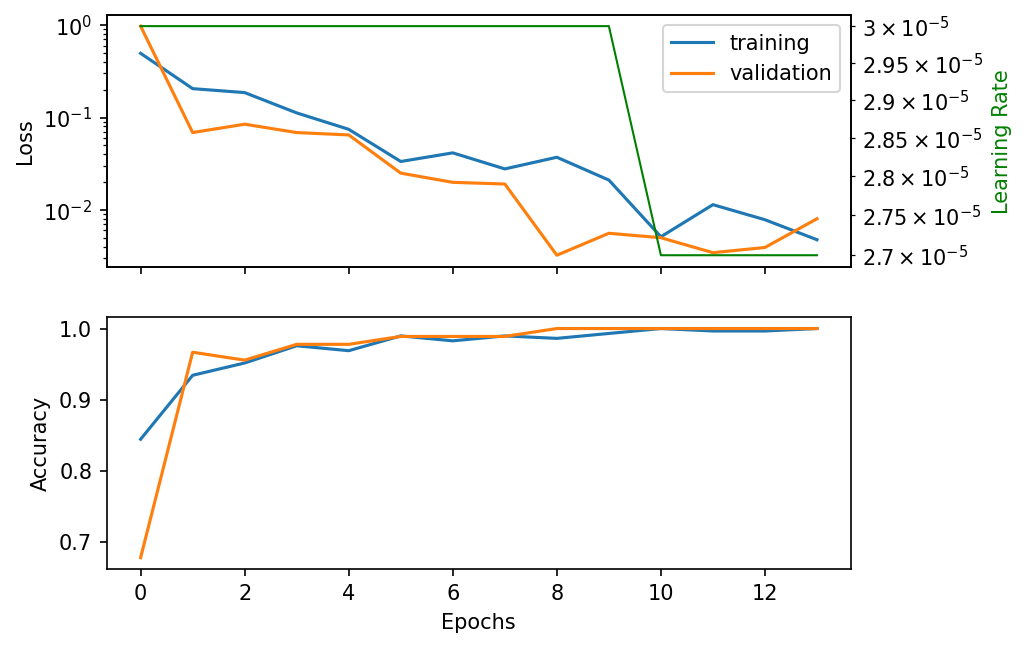

In [26]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    verbose=2,
    callbacks=[LRDecayCallback, StopCallback],
)

utils.plot_history( history )

**Notes on fine-tuning**:

- Fine-tuning should only be attempted *after* you have trained the new head layers with the frozen pre-trained model.
- Depending on the amount of training data available, you might fine-tune only *few layers* of the pre-trained model rather than all layers of the pre-trained model.

# 4 - Interpreting ConvNets

Run the cell below to restore a checkpoint where the model was already fine-tuned on the dataset.

In [ ]:
#@title Restore fine-tuned model from checkpoint
import os
ckp_path = '/tmp/checkpoints/ToBeeOrNotToBee_small_nopad_256px_vgg16_fine_tuned'
os.makedirs(ckp_path, exist_ok=True)
DEST_PATH = os.path.join(ckp_path, 'model.zip')

# download and unzip
!wget -nv -t 0 --show-progress -O $DEST_PATH 'https://cloud.tu-ilmenau.de/s/KomoKNWLKEXQd33/download/ToBeeOrNotToBee_small_nopad_256px_vgg16_fine_tuned.zip'
!sleep 1
!unzip -uq $DEST_PATH
!rm  $DEST_PATH

# restore model
model.load_weights(os.path.join( os.path.basename(ckp_path), 'model'))

Evaluation using this checkpoint should return close to 98% accuracy on the test data:

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('\nloss: {:.4f}\nacc: {:.4f}'.format(loss, accuracy))

## 4.1 - Visualizing Feature Maps

Feature maps display the output of a convolution layer after forwarding the input data through the network. The idea of visualizing a feature map for a specific input image would be to understand what features of the input are activated in a feature map. We expect feature maps close to the input to activate small details, such as corners, edges, as well as colors, whereas feature maps close to the output of the model capture more abstract and high-level concepts.

First, we need a clearer idea about the output shape and layer index of the convolution layers:

In [ ]:
print("idx | layer.name | output.shape", "*"*40, sep="\n")
for layer_idx, layer in enumerate(pre_trained_model.layers):
  # check if convolutional layer
  if not 'convolutional' in str(layer.__class__):
    continue
  print(layer_idx, layer.name, layer.output.shape, sep=" | ")

You can now use this information for designing a new model that contains a subset of the layers from the full VGG16 model. The model would have similar input layer as your original model, but the output would be the output of a given convolutional layer.

**Task**: Create a new model `visualization_model` that returns the output of the first convolutional layer (`layer_idx=1`):

**Hint**: Use the `layers` property of the model and the `output` property of the respective layer.

In [ ]:
### START YOUR CODE HERE ### (1 LOC)
visualization_model = Model(
    inputs=,
    outputs=,
    name='feature_map_model'
)
### END YOUR CODE HERE ###

print(visualization_model.summary())

Let's pick a random image from your validation data for exploring the feature map visualizations:

In [ ]:
def show(img):
  '''display image'''
  plt.figure(figsize=(6,6))
  plt.grid(False)
  plt.axis('Off')
  plt.imshow(img)
  plt.show()

img = next(iter(val_ds.take(1)))[0][3].numpy()
show(img)

# expand dimensions so that it fakes a batch containing a single sample
img = np.expand_dims(img, axis=0)

You are now ready to get the feature maps by forwarding the image through the network calling `visualization_model.predict()`.

The result will be feature maps with shape `(150, 150, 64)`. Let's plot the result as an 8x8 array of images.

In [ ]:
feature_maps = visualization_model.predict(img)

In [ ]:
#@title Plot feature maps
square = 8
fig = plt.gcf()
fig.set_size_inches(square*2,square*2)
idx = 1
for _ in range(square):
  for _ in range(square):
    sp = plt.subplot(square, square, idx)
    sp.axis('Off')
    sp.title.set_text(str(idx-1))
    plt.imshow(feature_maps[0, :, :, idx-1])
    idx += 1

plt.show()

You can see that the result of applying the filters of the first convolution layer is a lot of versions of the original flower image with different features highlighted.

In order to print feature maps of deeper convolution layers, you simply update the `visualization_model` for the index of the targeted layer. You can also collect feature maps from each block of the model in a single forward pass, and then create a square of images for each block.

In the VGG16 architecture, there are five main blocks `block1`, `block2`, and so on. The layer_indices of the last convolutional layer in each block are `[2, 5, 9, 13, 17]`.

**Task**: Define a new `visualization_model` that returns the outputs of the first convolutional layers in each block:

In [ ]:
### START YOUR CODE HERE ### (≈2 LOC)
layer_indices =
visualization_model = Model(
    inputs=,
    outputs=
)
### END YOUR CODE HERE ###

For sake of visibility, let us cap the number of displayed feature maps per layer at 16:

In [ ]:
#@title Plot feature maps
plt.imshow(img[0])
plt.axis('Off')
plt.title('Input Image')
plt.show()

square = 8
feature_maps = visualization_model.predict(img)
for layer_idx, fmap in enumerate(feature_maps):
  fig = plt.gcf()
  fig.set_size_inches(square*2,square*2)
  fig.suptitle( pre_trained_model.layers[ layer_indices[layer_idx] ].name )
  idx = 0
  for _ in range(square):
    for _ in range(2):
      fm = fmap[0, :, :, idx]
      sp = plt.subplot(square, square, idx+1)
      sp.axis('Off')
      sp.title.set_text(str(idx))
      plt.imshow(fm)
      idx += 1

  plt.show()

As expected, the feature maps closer to the input capture a lot of fine details in the image. As you progress deeper into the model, the feature maps show less and less details. Some channels show large activations at the original location of the flower in the image.

Analyzing all channels would be rather time-consuming. Instead, let's visualize where your model *looks* on average, i.e., the average of the feature maps:

In [ ]:
#@title Plot average feature maps
plt.imshow(img[0])
plt.axis('Off')
plt.title('Input Image')
plt.show()

fig=plt.figure(figsize=(14, 14))
for layer_idx, fmap in enumerate(feature_maps):
  sp = fig.add_subplot(1, len(feature_maps), layer_idx+1)
  sp.axis('Off')
  sp.title.set_text(pre_trained_model.layers[ layer_indices[layer_idx] ].name)
  plt.imshow(np.squeeze(fmap.mean(axis=-1)))

Instead of plotting the average of the feature maps, it can be quite informative to visualize the feature map that had the largest overall activation:

In [ ]:
#@title Plot max activation feature maps
plt.imshow(img[0])
plt.axis('Off')
plt.title('Input Image')
plt.show()

fig=plt.figure(figsize=(14, 14))
for layer_idx, fmap in enumerate(feature_maps):
  sp = fig.add_subplot(1, len(feature_maps), layer_idx+1)
  sp.axis('Off')
  sp.title.set_text(pre_trained_model.layers[ layer_indices[layer_idx] ].name)
  max_idx = np.argmax(np.sum(fmap, axis=(1,2)), axis=-1)
  plt.imshow(np.squeeze(fmap[:,:,:,max_idx]))

## 4.2 - Visualizing Convolution Filters

Now that you learned how to analyze where your network *looks*, let us visualize how your network actually perceives images. In detail, you will visualize input patterns that activate specific filters of your network by **activation maximization**.

The idea is to optimize the pixel values of a random input image via **gradient ascent** in order to maximize the average of a specific feature map.

For performing gradient ascent, you need to:
1. Freeze the network (you don't want to update any weights of the network).
2. Forward a randomly initialized image through the network.
3. Compute the average of a specific feature map in a layer.
4. Compute the gradient of the average feature map with respect to the pixel values of the input image.
5. Update the pixel values based on the backpropagated gradient.
6. Repeat steps 2-5

Make it so!

**Task**: Freeze all layers of `model`.

In [ ]:
from tensorflow.keras import backend as K
import tensorflow as tf

### START YOUR CODE HERE ### (≈2 LOC)

### END YOUR CODE HERE ###

**Task**: Define `vis_model` to output the feature map specified by `filter_idx` of the layer specified by `layer_idx`.

**Hint**: The shape of a convolution layer's output is `(num_samples, width, height, num_filters)`.

In [ ]:
def deprocess(img):
  return tf.cast( 255*(img[0,:] + 1.) / 2., tf.uint8)

def calc_loss(img, model):
  '''Compute loss as average activation of the model'''
  return K.mean( model(img) )

def filter_activation_maximization(model, img, layer_idx, filter_idx,
                                   steps=100,
                                   step_size=1,
                                   vis_steps=100,
                                   display=True):

  # Define the model
  ### START YOUR CODE HERE ### (1 LOC)
  vis_model = Model(
      inputs=,
      outputs=
  )
  ### END YOUR CODE HERE ###

  for step in range(steps):
    with tf.GradientTape() as gtape:
      gtape.watch(img)
      loss = calc_loss(img, vis_model)

    # Compute the gradient of the loss with respect to the input image
    grads = gtape.gradient(loss, img)

    # Normalize the gradients
    grads = K.l2_normalize(grads) + 1e-8

    if np.mean(np.abs(grads)) < 1e-7:
      print(f"filter_idx {filter_idx} - skipping, gradient too small: {np.mean(np.abs(grads)):.3g}")
      break

    # Perform gradient ascent to make the image increasingly activate the filter
    img += grads*step_size
    img = tf.clip_by_value(img, -1, 1)

    if ((step+1) % vis_steps == 0) or step+1 == steps:
      print(f'filter_idx {filter_idx} - step {step+1} - loss: {loss:.3g} - avg. gradient: {np.mean(np.abs(grads)):.3g}')
      if display:
        show( deprocess(img) )
  return img

Now run `filter_activation_maximization` on an image initialized with random noise and visualize the input patterns activating the first twelve filters of the first convolution layer (`layer_idx = 1`).

In [ ]:
# Define the layer to be activated
layer_idx = 1

# Define the layer's filter to be activated
filter_idx = 0  # Try out different filters

# Init random gray image with some noise
img = tf.cast( np.random.random((1,) + INPUT_SHAPE)*.1 +.3 , tf.float32 )

# Run activation maximization
img2 = filter_activation_maximization(
    pre_trained_model,
    img,
    layer_idx,
    filter_idx,
    200, 3, 200
)

In [ ]:
def visualize_filters(layer_idx, num_filters, start_idx=0):

  filter_indices = np.arange(start_idx, start_idx+num_filters, 1)

  fig = plt.gcf()
  fig.set_size_inches(num_filters*2, num_filters/2)
  fig.suptitle( pre_trained_model.layers[ layer_idx ].name )

  for idx, filter_idx in enumerate(filter_indices):
    filter_idx_offset = 0
    img = filter_activation_maximization(
        pre_trained_model,
        tf.cast( np.random.random((1,) + INPUT_SHAPE)*.1 +.3 , tf.float32 ),
        layer_idx,
        filter_idx + filter_idx_offset,
        steps=200,
        step_size=2,
        display=False
    )

    sp = plt.subplot(num_filters // 6, 6, idx+1)
    sp.axis('Off')
    sp.title.set_text(str(filter_idx))
    plt.imshow(deprocess(img))

  plt.show()

In [ ]:
layer_idx = 1
num_filters = 12

visualize_filters(layer_idx, num_filters)

Filter of later layers activate more abstract high-level concepts:

In [ ]:
layer_idx = 4
num_filters = 6

visualize_filters(layer_idx, num_filters)

In [ ]:
layer_idx = 7
num_filters = 6

visualize_filters(layer_idx, num_filters)

In [ ]:
layer_idx = 11
num_filters = 6

visualize_filters(layer_idx, num_filters)

In [ ]:
layer_idx = 15
num_filters = 6

visualize_filters(layer_idx, num_filters)

In [ ]:
layer_idx = 17
num_filters = 12

visualize_filters(layer_idx, num_filters, start_idx=13)

***

# Congratulations!

You've learned how to apply **Transfer Learning** and **Fine-tuning** of large models on small datasets. In addition, you learned how to use **learning rate schedules** and **early stopping** as **CallBacks**. At last, you saw how your model can be tweaked to return intermediate results such as feature maps and how to do **activation maximization** for interpreting the filters your model has learned.

***